# Libraries with secondary target genes
A [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) is designed to handle mutations to a specific target gene.
But in some cases, you might also want to include specific targets that are **not** point mutants of this primary target gene, but rather are entirely different genes that are spiked into the library as a control or for comparison.
Because these secondary targets might not be closely related to the primary target gene, we do not want to define them simply by their mutations relative to the primary target.
Rather, we handle them as different targets by adding a "targets" column in the data.

This notebook illustrates how to do this.

## Setup for analysis

Import Python modules / packages:

In [1]:
import itertools
import random
import tempfile
import warnings

import numpy

import pandas as pd

from plotnine import *

import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Set parameters that define the simulated data for the primary target gene.
Except for that fact that we use a short gene to reduce the computational run-time of this notebook, these simulation parameters are designed to reflect what we might observe in a real Bloom lab deep mutational scanning experiment:

In [2]:
primary_target = "primary_target_gene"
seed = 1  # random number seed
genelength = 30  # gene length in codons
libs = ["lib_1", "lib_2"]  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.0  # average codon mutations per variant
bclen = 16  # length of nucleotide barcode for each variant
variant_error_rate = 0.005  # rate at which variant sequence mis-called
avgdepth_per_variant = 200  # average per-variant sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.02  # random noise in selections
bottlenecks = {  # bottlenecks from pre- to post-selection
    "tight_bottle": variants_per_lib * 5,
    "loose_bottle": variants_per_lib * 100,
}

We also define some secondary targets:

In [3]:
secondary_targets = [f"secondary_target_{i}" for i in range(1, 4)]

Seed random number generator for reproducible output:

In [4]:
random.seed(seed)
numpy.random.seed(seed)

Set pandas display options to show large chunks of Data Frames in this
example:

In [5]:
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 500)

Hide warnings that clutter output:

In [6]:
warnings.simplefilter("ignore")

Set the gray grid [plotnine theme](https://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.theme.html?highlight=themes) defined in [dms_variants.plotnine_themes](https://jbloomlab.github.io/dms_variants/dms_variants.plotnine_themes.html) as this gives a nice appearance for the plots:

In [7]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate library with primary and secondary variants
Simulate wildtype gene sequence:

In [8]:
geneseq = "".join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 30 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTG


Generate a
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
using
[simulate_CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulate_CodonVariantTable)
function, then get the barcode-variant data frame for it.
This data frame gives the variants for the **primary** target:

In [9]:
primary_bc_variant_df = dms_variants.simulate.simulate_CodonVariantTable(
    geneseq=geneseq,
    bclen=bclen,
    library_specs={
        lib: {"avgmuts": avgmuts, "nvariants": variants_per_lib} for lib in libs
    },
    seed=seed,
).barcode_variant_df

primary_bc_variant_df.head()

,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,lib_1,AAAAAAAACGTTTTGT,1,CTG5TGG TCA11TCT,L5W,2,1
1,lib_1,AAAAAAAGGCTTATAC,5,TCA11TGC,S11C,1,1
2,lib_1,AAAAAAATCGTCCGTG,2,,,0,0
3,lib_1,AAAAAAGACAACACCG,5,ATC25TTC,I25F,1,1
4,lib_1,AAAAAAGATGTGGTGG,3,TCA11TTA CGG12GGT CGT15TGA ATC25GGA ATC28CGC,S11L R12G R15* I25G I28R,5,5


This data frame gives variants for the primary target, so add a column specifying that fact:

In [10]:
primary_bc_variant_df = primary_bc_variant_df.assign(target=primary_target)

Now add some barcodes for each secondary targets.
We simulate barcodes for each secondary target and each library.
Note that the secondary targets are defined genes, so we don't add any information on substitutions for these:

In [11]:
existing_barcodes = set(primary_bc_variant_df["barcode"])

secondary_bc_variant_df = []
for lib, secondary_target in itertools.product(libs, secondary_targets):
    secondary_target_barcodes = dms_variants.simulate.rand_seq(
        seqlen=bclen,
        exclude=existing_barcodes,
        nseqs=random.randint(50, 100),
    )
    existing_barcodes = existing_barcodes.union(secondary_target_barcodes)
    secondary_bc_variant_df.append(
        pd.DataFrame(
            {
                "target": secondary_target,
                "barcode": secondary_target_barcodes,
                "library": lib,
                "variant_call_support": 10,
            }
        )
    )

secondary_bc_variant_df = pd.concat(secondary_bc_variant_df, ignore_index=True)

secondary_bc_variant_df.head()

,target,barcode,library,variant_call_support
0,secondary_target_1,TCCTGTACGATATCCC,lib_1,10
1,secondary_target_1,GGGTGTGGCGTTTCCT,lib_1,10
2,secondary_target_1,TAGCCTCTATTGCCTT,lib_1,10
3,secondary_target_1,CGGAGACGTCACGGCG,lib_1,10
4,secondary_target_1,GGGGACAATTATCCCT,lib_1,10


Concatenate the data frame for the primary target (which has mutants) with that for the secondary targets.
Because there are no mutations for the secondary targets, fill that information is as empty strings (for substitution columns) or 0 (for number of mutations).
This data frame below ends the simulation of the library, and represents the type of information you would typically have at the outset of an experiment:

In [12]:
bc_variant_df = pd.concat(
    [primary_bc_variant_df, secondary_bc_variant_df], sort=False
).assign(
    codon_substitutions=lambda x: x["codon_substitutions"].fillna(""),
    aa_substitutions=lambda x: x["aa_substitutions"].fillna(""),
    n_codon_substitutions=lambda x: x["n_codon_substitutions"].fillna(0).astype(int),
    n_aa_substitutions=lambda x: x["n_aa_substitutions"].fillna(0).astype(int),
)

bc_variant_df

,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,target
0,lib_1,AAAAAAAACGTTTTGT,1,CTG5TGG TCA11TCT,L5W,2,1,primary_target_gene
1,lib_1,AAAAAAAGGCTTATAC,5,TCA11TGC,S11C,1,1,primary_target_gene
2,lib_1,AAAAAAATCGTCCGTG,2,,,0,0,primary_target_gene
3,lib_1,AAAAAAGACAACACCG,5,ATC25TTC,I25F,1,1,primary_target_gene
4,lib_1,AAAAAAGATGTGGTGG,3,TCA11TTA CGG12GGT CGT15TGA ATC25GGA ATC28CGC,S11L R12G R15* I25G I28R,5,5,primary_target_gene
...,...,...,...,...,...,...,...,...
429,lib_2,GCGGCCTGGAGTTGAA,10,,,0,0,secondary_target_3
430,lib_2,TGATCACTACGTCCTT,10,,,0,0,secondary_target_3
431,lib_2,TTTAGGAATCTCCCGT,10,,,0,0,secondary_target_3
432,lib_2,TGTGCTTAGAGCACCG,10,,,0,0,secondary_target_3


Now create the [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable).
Note how we specify the `primary_target` option to the name of that target; this is required when using multiple targets:

In [13]:
with tempfile.NamedTemporaryFile() as f:
    bc_variant_df.to_csv(f.name, index=False)
    f.flush()
    variants = dms_variants.codonvarianttable.CodonVariantTable(
        barcode_variant_file=f.name,
        geneseq=geneseq,
        substitutions_are_codon=True,
        substitutions_col="codon_substitutions",
        primary_target=primary_target,
    )

We can get basic information about the [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable), such as the sites, wildtype codons, and wildtype amino acids.
Below we do this for the first few sites.
Note that all of this information is for the **primary target**:

In [14]:
variants.sites[:5]

[1, 2, 3, 4, 5]

In [15]:
list(variants.codons[r] for r in variants.sites[:5])

['AGA', 'TCC', 'GTG', 'ATT', 'CTG']

In [16]:
list(variants.aas[r] for r in variants.sites[:5])

['R', 'S', 'V', 'I', 'L']

The different libraries in the table:

In [17]:
variants.libraries

['lib_1', 'lib_2']

Here is the data frame that contains all of the information on the barcoded variants.
Note that the list of substitutions for the secondary targets just repeat the target name (so you are not confused with thinking mutations are actually enumerated in these secondary targets):

In [18]:
variants.barcode_variant_df

,target,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,primary_target_gene,lib_1,AAAAAAAACGTTTTGT,1,CTG5TGG TCA11TCT,L5W,2,1
1,primary_target_gene,lib_1,AAAAAAAGGCTTATAC,5,TCA11TGC,S11C,1,1
2,primary_target_gene,lib_1,AAAAAAATCGTCCGTG,2,,,0,0
3,primary_target_gene,lib_1,AAAAAAGACAACACCG,5,ATC25TTC,I25F,1,1
4,primary_target_gene,lib_1,AAAAAAGATGTGGTGG,3,TCA11TTA CGG12GGT CGT15TGA ATC25GGA ATC28CGC,S11L R12G R15* I25G I28R,5,5
...,...,...,...,...,...,...,...,...
30429,secondary_target_3,lib_2,TGTGCTTAGAGCACCG,10,secondary_target_3,secondary_target_3,0,0
30430,secondary_target_3,lib_2,TTCCGACACGTTGACC,10,secondary_target_3,secondary_target_3,0,0
30431,secondary_target_3,lib_2,TTCTATTACGCTGGGG,10,secondary_target_3,secondary_target_3,0,0
30432,secondary_target_3,lib_2,TTCTTACTGAAGTTCC,10,secondary_target_3,secondary_target_3,0,0


## Analyze library composition
A [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
has methods for summarizing and plotting properties of the barcoded variants.
These methods can be used to analyze the barcoded variants themselves, or to
analyze the frequency (or counts) of variants in the library in samples that
have undergone some type of selection.

We have not yet added counts of the
variants in any specific samples, so we just analyze the composition of the
variant library itself.
This is done by setting `samples=None` in the method
calls below.

Number of variants in each library:

In [19]:
variants.n_variants_df(samples=None)

,target,library,sample,count
0,primary_target_gene,lib_1,barcoded variants,15000
1,primary_target_gene,lib_2,barcoded variants,15000
2,primary_target_gene,all libraries,barcoded variants,30000
3,secondary_target_1,lib_1,barcoded variants,52
4,secondary_target_1,lib_2,barcoded variants,82
5,secondary_target_1,all libraries,barcoded variants,134
6,secondary_target_2,lib_1,barcoded variants,89
7,secondary_target_2,lib_2,barcoded variants,69
8,secondary_target_2,all libraries,barcoded variants,158
9,secondary_target_3,lib_1,barcoded variants,87


We can also get this information for just the primary target:

In [20]:
variants.n_variants_df(samples=None, primary_target_only=True)

,library,sample,count
0,lib_1,barcoded variants,15000
1,lib_2,barcoded variants,15000
2,all libraries,barcoded variants,30000


Plot distribution of variant call supports, grouping together all variants with support $\ge 8$:

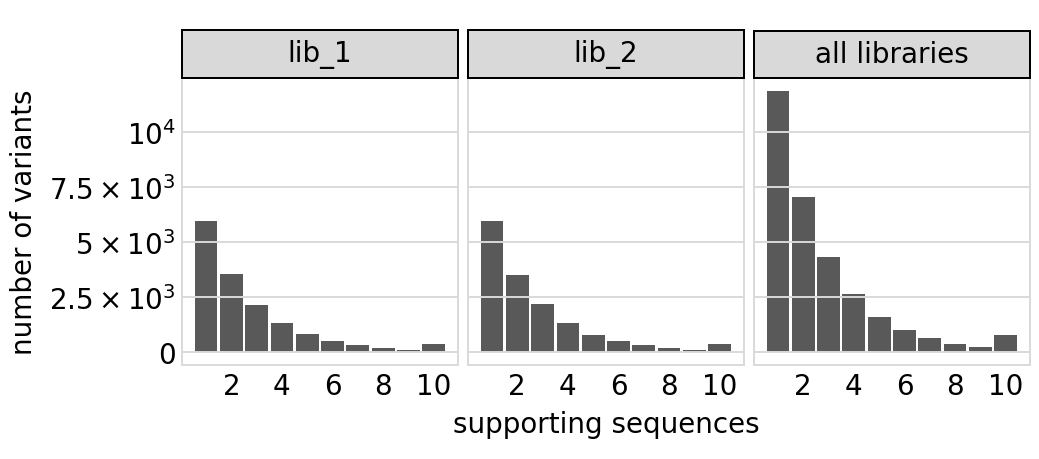

In [21]:
# NBVAL_IGNORE_OUTPUT

p = variants.plotVariantSupportHistogram(max_support=10)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)

Same plot for only the primary target:

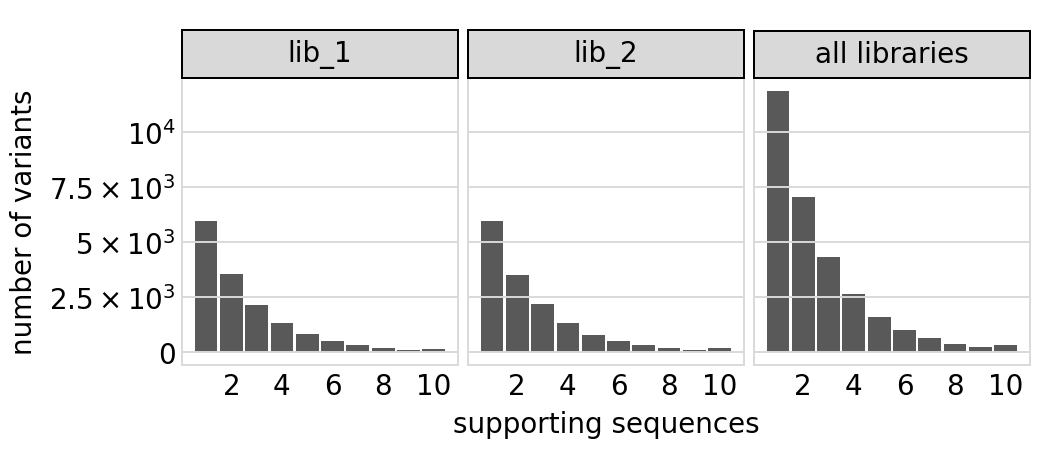

In [22]:
# NBVAL_IGNORE_OUTPUT

p = variants.plotVariantSupportHistogram(max_support=10, primary_target_only=True)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)

The set of valid barcodes for each library:

In [23]:
for lib in libs:
    print(f"First few barcodes for library {lib}:")
    print(sorted(variants.valid_barcodes(lib))[:3])

First few barcodes for library lib_1:
['AAAAAAAACGTTTTGT', 'AAAAAAAGGCTTATAC', 'AAAAAAATCGTCCGTG']
First few barcodes for library lib_2:
['AAAAAACCCAGACTTA', 'AAAAAACCGGCGGCAG', 'AAAAAATCTACTGCGT']


Plot the number of amino-acid mutations per variant.
Note that this plot is **only** for the primary target:

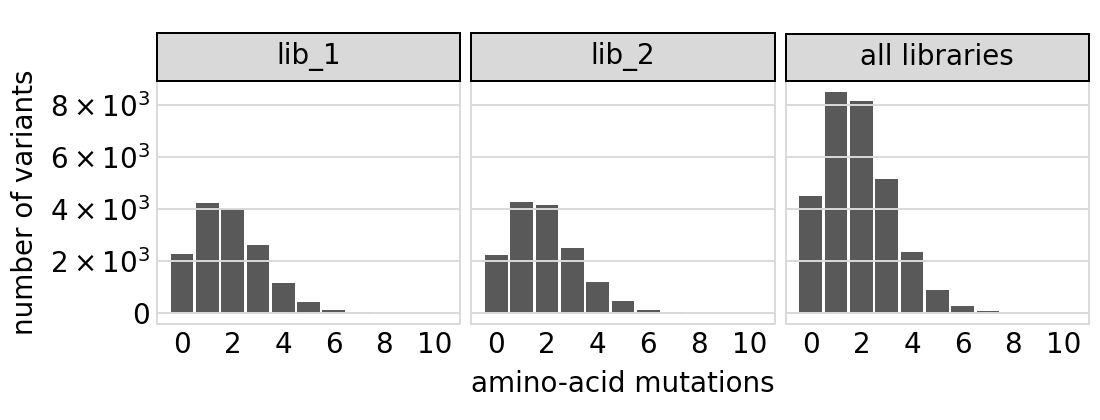

In [24]:
# NBVAL_IGNORE_OUTPUT

p = variants.plotNumMutsHistogram("aa", samples=None)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)

Average number of codon mutations per variant of each type of mutation.
We make these plots for:
 1. Just single-mutant and wildtype variants
 2. For all variants
 
Again, these are **only** for the primary target, since mutations are only defined for that target:

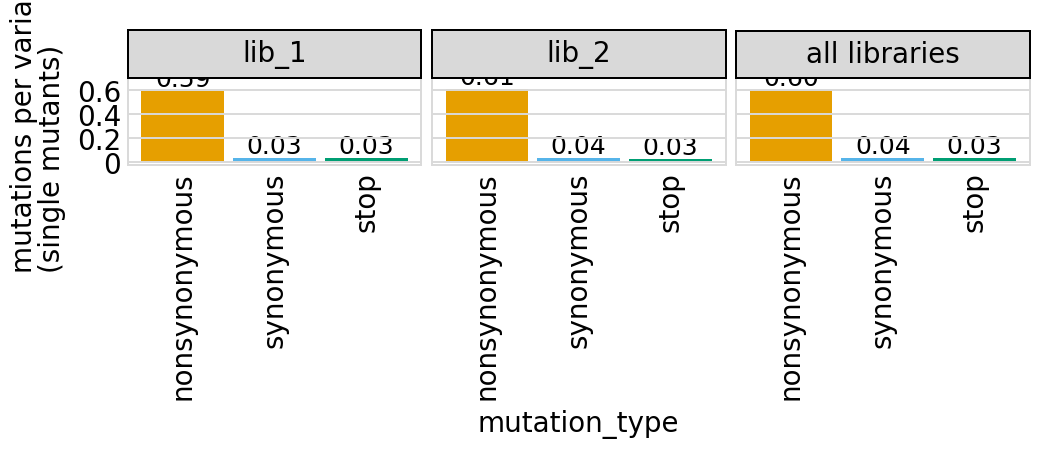

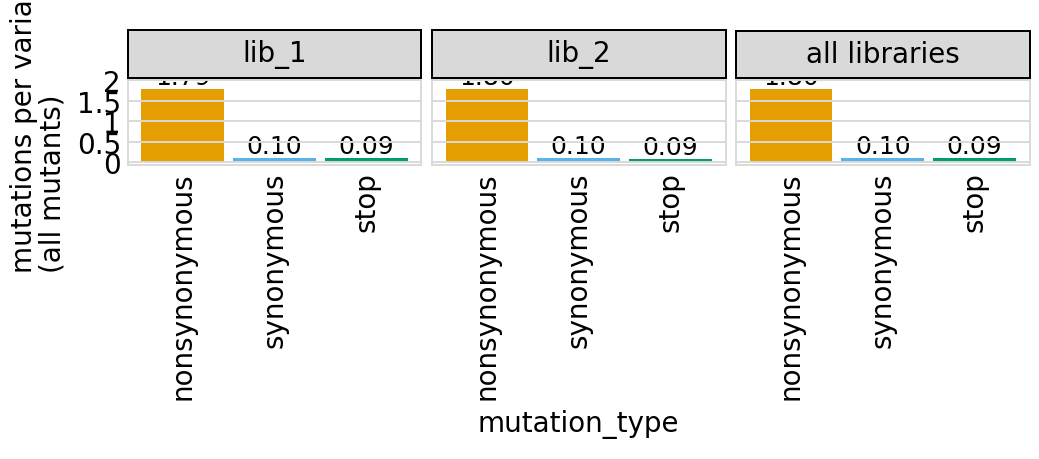

In [25]:
# NBVAL_IGNORE_OUTPUT

for mut_type in ["single", "all"]:
    p = variants.plotNumCodonMutsByType(mut_type, samples=None)
    p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    _ = p.draw(show=True)

Here are the numerical data in the plots above:

In [26]:
variants.numCodonMutsByType("single", samples=None).round(3)

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,barcoded variants,nonsynonymous,3615,6112,0.591
1,lib_1,barcoded variants,synonymous,194,6112,0.032
2,lib_1,barcoded variants,stop,211,6112,0.035
3,lib_2,barcoded variants,nonsynonymous,3716,6114,0.608
4,lib_2,barcoded variants,synonymous,235,6114,0.038
5,lib_2,barcoded variants,stop,179,6114,0.029
6,all libraries,barcoded variants,nonsynonymous,7331,12226,0.600
7,all libraries,barcoded variants,synonymous,429,12226,0.035
8,all libraries,barcoded variants,stop,390,12226,0.032


In [27]:
variants.numCodonMutsByType("all", samples=None).round(3)

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,barcoded variants,nonsynonymous,26916,15000,1.794
1,lib_1,barcoded variants,synonymous,1510,15000,0.101
2,lib_1,barcoded variants,stop,1424,15000,0.095
3,lib_2,barcoded variants,nonsynonymous,26960,15000,1.797
4,lib_2,barcoded variants,synonymous,1498,15000,0.100
5,lib_2,barcoded variants,stop,1371,15000,0.091
6,all libraries,barcoded variants,nonsynonymous,53876,30000,1.796
7,all libraries,barcoded variants,synonymous,3008,30000,0.100
8,all libraries,barcoded variants,stop,2795,30000,0.093


Examine how well amino-acid mutations **to the primary target** are sampled in the library by looking at the
fraction of mutations seen <= some number of times.
Here we do that for amino-acid mutations, making separate plots for single mutants and all mutants:

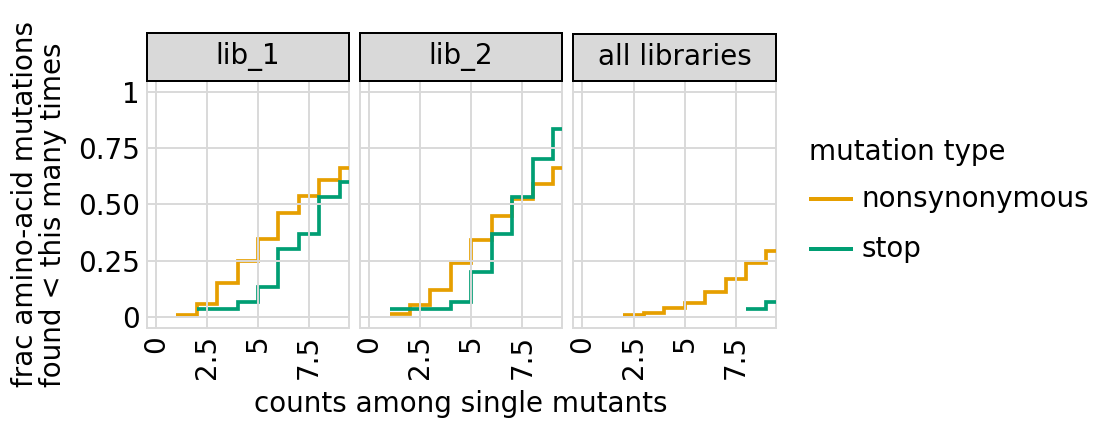

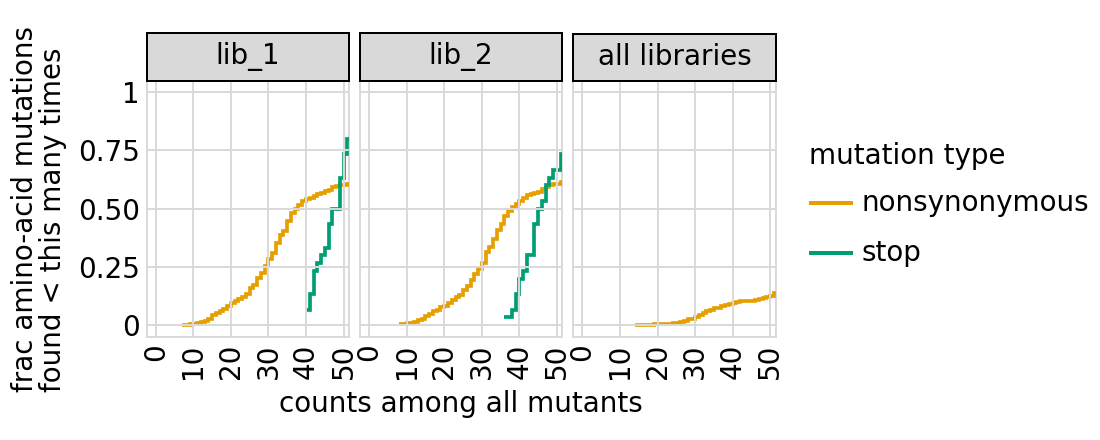

In [28]:
# NBVAL_IGNORE_OUTPUT

for variant_type in ["single", "all"]:
    p = variants.plotCumulMutCoverage(variant_type, mut_type="aa", samples=None)
    _ = p.draw(show=True)

We can also get the numerical information plotted above (here for single mutants
only):

In [29]:
variants.mutCounts("single", "aa", samples=None).head(n=5)

,library,sample,mutation,count,mutation_type,site
0,lib_1,barcoded variants,V16L,25,nonsynonymous,16
1,lib_1,barcoded variants,C19R,21,nonsynonymous,19
2,lib_1,barcoded variants,R12S,21,nonsynonymous,12
3,lib_1,barcoded variants,R26L,21,nonsynonymous,26
4,lib_1,barcoded variants,S11R,21,nonsynonymous,11


Here are the frequencies of mutations along the **primary target** gene, looking both at single mutants and all mutants:

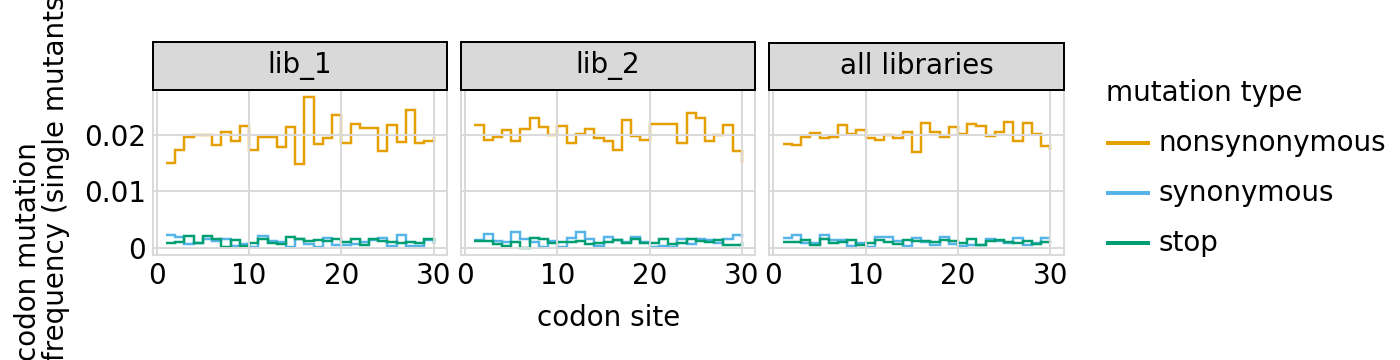

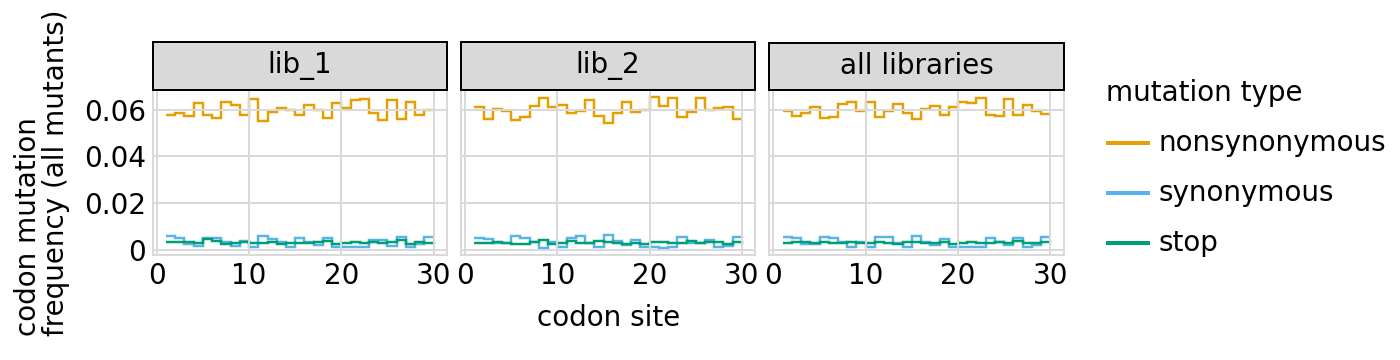

In [30]:
# NBVAL_IGNORE_OUTPUT

for variant_type in ["single", "all"]:
    p = variants.plotMutFreqs(variant_type, "codon", samples=None)
    _ = p.draw(show=True)

We can also look at mutation frequencies in the primary target gene a heat-map form:

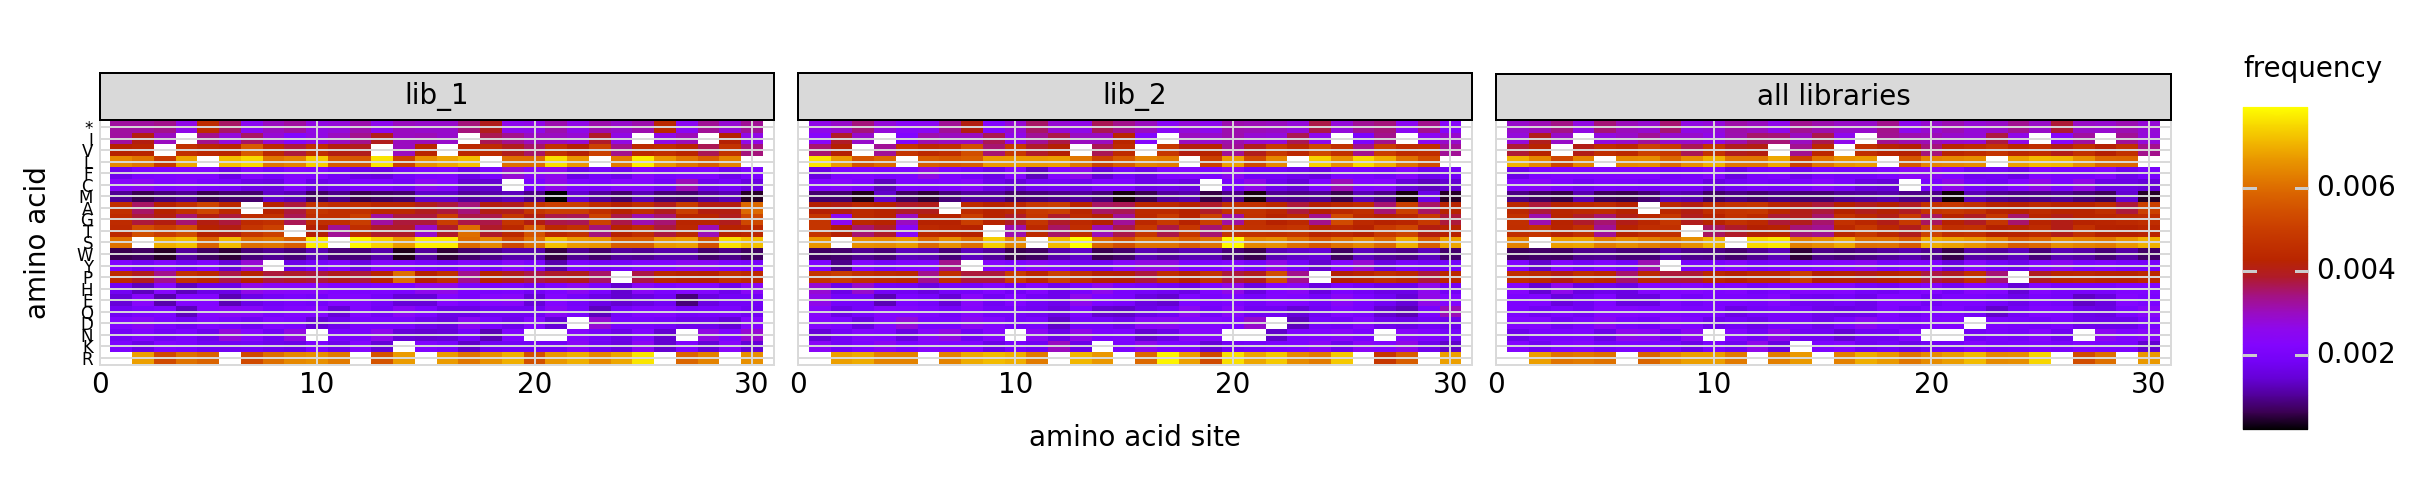

In [31]:
# NBVAL_IGNORE_OUTPUT

p = variants.plotMutHeatmap("all", "aa", samples=None)
_ = p.draw(show=True)

## Simulate counts for samples
An experiment involves subjecting the library to
different selections and looking at how the frequencies of the variants changes
by using sequencing to count the barcodes in each condition.

Here, we simulate
an experiment by simulating variant counts for samples that have undergone
various selections.

For these simulations, we first need to define a
"phenotype" for each variant.
The phenotype represents how much the frequency of
the variant is expected to increase or decrease after selection.

### Define phenotype function
First, we define a “phenotype” function. We will
do this using a
[SigmoidPhenotypeSimulator](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.SigmoidPhenotypeSimulator),
which follow the "global epistasis" concepts of [Otwinoski et
al](https://doi.org/10.1073/pnas.1804015115) and [Sailer and
Harms](https://doi.org/10.1534/genetics.116.195214) to define the phenotype in
two steps: an underlying latent phenotype that mutations affect additively, and
then an observed phenotype that is a non-linear
function of the latent phenotype.
The variants are then simulated according to their observed enrichments, which are the exponentials of the observed phenotypes.

First, we initialize the simulator:

In [32]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(geneseq, seed=seed)

Plot the simulated relationship of the latent phenotype with the observed enrichment and phenotype, with a dashed
vertical line indicating the wildtype latent phenotype:

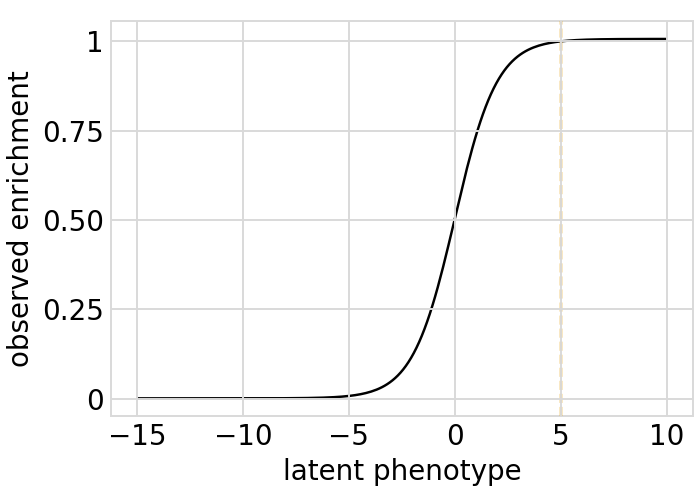

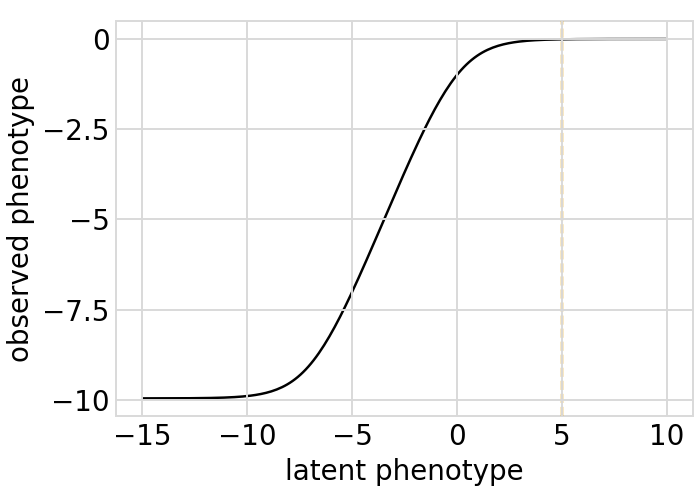

In [33]:
# NBVAL_IGNORE_OUTPUT

for value in ["enrichment", "phenotype"]:
    p = phenosimulator.plotLatentVsObserved(value)
    _ = p.draw(show=True)

Plot the latent phenotype, observed phenotype, and observed enrichment of all single amino-acid mutants, with a
dashed vertical line indicating the wildtype:

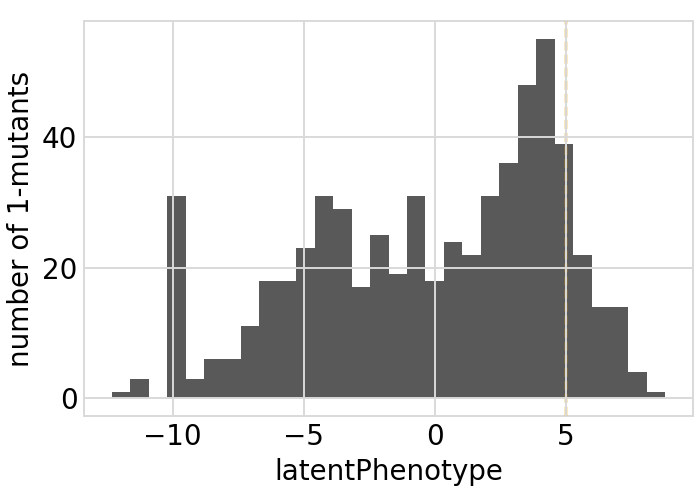

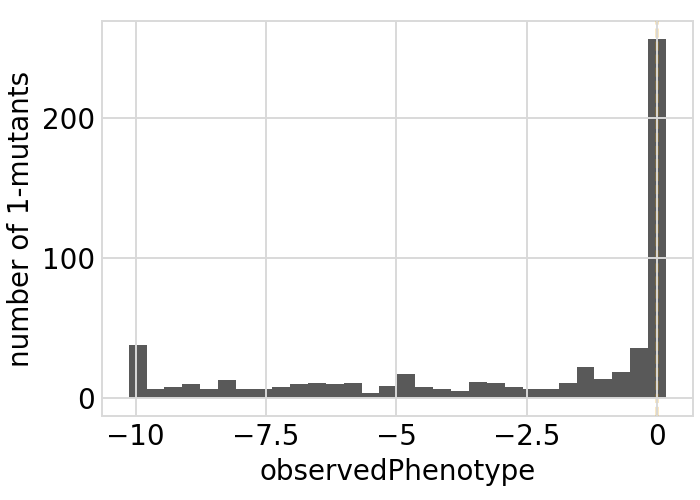

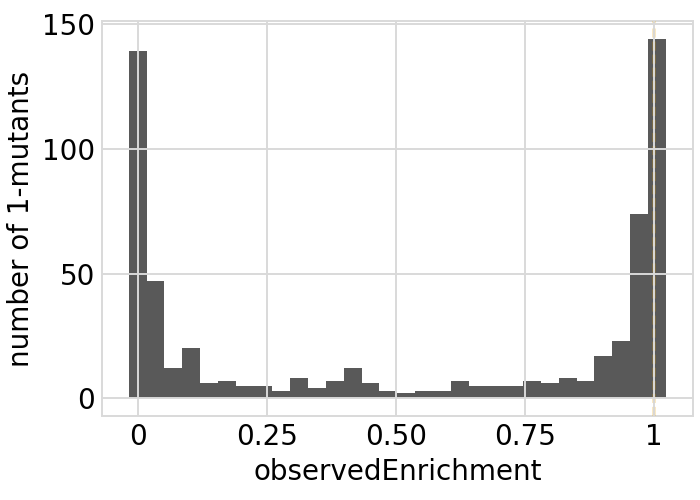

In [34]:
# NBVAL_IGNORE_OUTPUT

for value in ["latentPhenotype", "observedPhenotype", "observedEnrichment"]:
    p = phenosimulator.plotMutsHistogram(value)
    _ = p.draw(show=True)

### Phenotypes for secondary targets
We also specify phenotypes as observed enrichments for the secondary targets:

In [35]:
secondary_target_phenotypes = {
    secondary_target: round(random.uniform(0.2, 2), 3)
    for secondary_target in secondary_targets
}

# display the observed enrichments for the secondary targets
pd.Series(secondary_target_phenotypes).rename("observed_enrichment").to_frame()

,observed_enrichment
secondary_target_1,0.883
secondary_target_2,1.211
secondary_target_3,1.789


### Simulate variant counts
Now we use
[simulateSampleCounts](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulateSampleCounts)
to simulate counts of variants when selection on each variant is proportional to
its observed enrichment.
In these simulations, we can fine-tune the simulations
to reflect real experiments, such as by setting the error-rate in variant
calling, bottlenecks when going from the pre- to post-selection samples, and
non-uniformity in library composition.

Here we simulate using several
bottlenecks in the library going from the pre- to post-selection samples, since
in real experiments this seems to be the biggest source of noise / error:

In [36]:
counts = dms_variants.simulate.simulateSampleCounts(
    variants=variants,
    phenotype_func=phenosimulator.observedEnrichment,
    variant_error_rate=variant_error_rate,
    pre_sample={
        "total_count": variants_per_lib * numpy.random.poisson(avgdepth_per_variant),
        "uniformity": lib_uniformity,
    },
    pre_sample_name="pre-selection",
    post_samples={
        name: {
            "noise": noise,
            "total_count": variants_per_lib
            * numpy.random.poisson(avgdepth_per_variant),
            "bottleneck": bottle,
        }
        for name, bottle in bottlenecks.items()
    },
    seed=seed,
    secondary_target_phenotypes=secondary_target_phenotypes,
)

Data frame with the simulated counts:

In [37]:
counts.head(6)

,library,barcode,sample,count
0,lib_1,AAAAAAAACGTTTTGT,pre-selection,317
1,lib_1,AAAAAAAGGCTTATAC,pre-selection,133
2,lib_1,AAAAAAATCGTCCGTG,pre-selection,127
3,lib_1,AAAAAAGACAACACCG,pre-selection,97
4,lib_1,AAAAAAGATGTGGTGG,pre-selection,324
5,lib_1,AAAAAAGTCATACTCG,pre-selection,118


### Add counts to variant table
Now add the simulated counts for each library /
sample to the
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable):

In [38]:
variants.add_sample_counts_df(counts)

Confirm that we have added the expected number of counts per library /
sample:

In [39]:
# NBVAL_IGNORE_OUTPUT

variants.n_variants_df(libraries="all_only")

,target,library,sample,count
0,primary_target_gene,all libraries,pre-selection,5439967
1,primary_target_gene,all libraries,loose_bottle,5366820
2,primary_target_gene,all libraries,tight_bottle,5916597
3,secondary_target_1,all libraries,pre-selection,23756
4,secondary_target_1,all libraries,loose_bottle,54373
5,secondary_target_1,all libraries,tight_bottle,57359
6,secondary_target_2,all libraries,pre-selection,29184
7,secondary_target_2,all libraries,loose_bottle,92595
8,secondary_target_2,all libraries,tight_bottle,98230
9,secondary_target_3,all libraries,pre-selection,27093


Look only for primary target:

In [40]:
# NBVAL_IGNORE_OUTPUT

variants.n_variants_df(primary_target_only=True)

,library,sample,count
0,lib_1,pre-selection,2719365
1,lib_1,loose_bottle,2674231
2,lib_1,tight_bottle,2949688
3,lib_2,pre-selection,2720602
4,lib_2,loose_bottle,2692589
5,lib_2,tight_bottle,2966909
6,all libraries,pre-selection,5439967
7,all libraries,loose_bottle,5366820
8,all libraries,tight_bottle,5916597


## Analyze sample variant counts
A
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
has methods for summarizing and plotting the variant counts for different
samples.
These methods are mostly the same as we used above to analyze the
variant composition of the libraries themselves, but now we set `samples` to the
samples that we want to analyze (typically `'all'`).
Therefore, rather than each
variant always counting once, each variant is counted in each sample in
proportion to how many counts it has.

In the rawest form, we can directly
access a data frame giving the counts of each variant in each sample:

In [41]:
# NBVAL_IGNORE_OUTPUT

variants.variant_count_df

,target,library,sample,barcode,count,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,primary_target_gene,lib_1,pre-selection,AACCCGTTCACCACCA,692,2,ATC17CGA CGG29TGC,I17R R29C,2,2
1,primary_target_gene,lib_1,pre-selection,ACTACGGACGATTATT,633,1,GCT7TCT AAA14GAT AAC20CGA,A7S K14D N20R,3,3
2,primary_target_gene,lib_1,pre-selection,GGACTATCTCAGTATG,615,2,,,0,0
3,primary_target_gene,lib_1,pre-selection,CCAGAAAACCCACCAA,614,7,TTA18CTC,,1,0
4,primary_target_gene,lib_1,pre-selection,ACGGCCTAAACTCACA,611,3,CGT6GTA GAC22CAC,R6V D22H,2,2
...,...,...,...,...,...,...,...,...,...,...
91297,secondary_target_3,lib_2,tight_bottle,CAACCTAATTGGGATC,187,10,secondary_target_3,secondary_target_3,0,0
91298,secondary_target_3,lib_2,tight_bottle,TGGGCACGATGCAATA,186,10,secondary_target_3,secondary_target_3,0,0
91299,secondary_target_3,lib_2,tight_bottle,ACGAGTACCCCACTTC,182,10,secondary_target_3,secondary_target_3,0,0
91300,secondary_target_3,lib_2,tight_bottle,TATATCGGCGTGAAGA,176,10,secondary_target_3,secondary_target_3,0,0


Get the **average** number of counts per variant:

In [42]:
# NBVAL_IGNORE_OUTPUT

variants.avgCountsPerVariant().round(1)

,target,library,sample,avg_counts_per_variant
0,primary_target_gene,lib_1,pre-selection,181.3
1,primary_target_gene,lib_1,loose_bottle,178.3
2,primary_target_gene,lib_1,tight_bottle,196.6
3,primary_target_gene,lib_2,pre-selection,181.4
4,primary_target_gene,lib_2,loose_bottle,179.5
5,primary_target_gene,lib_2,tight_bottle,197.8
6,primary_target_gene,all libraries,pre-selection,181.3
7,primary_target_gene,all libraries,loose_bottle,178.9
8,primary_target_gene,all libraries,tight_bottle,197.2
9,secondary_target_1,lib_1,pre-selection,166.1


Above the counts are grouped by target. To not group by target:

In [43]:
variants.avgCountsPerVariant(by_target=False).round(1)

,library,sample,avg_counts_per_variant
0,lib_1,pre-selection,181.2
1,lib_1,loose_bottle,185.2
2,lib_1,tight_bottle,203.9
3,lib_2,pre-selection,181.5
4,lib_2,loose_bottle,185.5
5,lib_2,tight_bottle,204.2
6,all libraries,pre-selection,181.4
7,all libraries,loose_bottle,185.3
8,all libraries,tight_bottle,204.0


We also plot the average counts per variant:

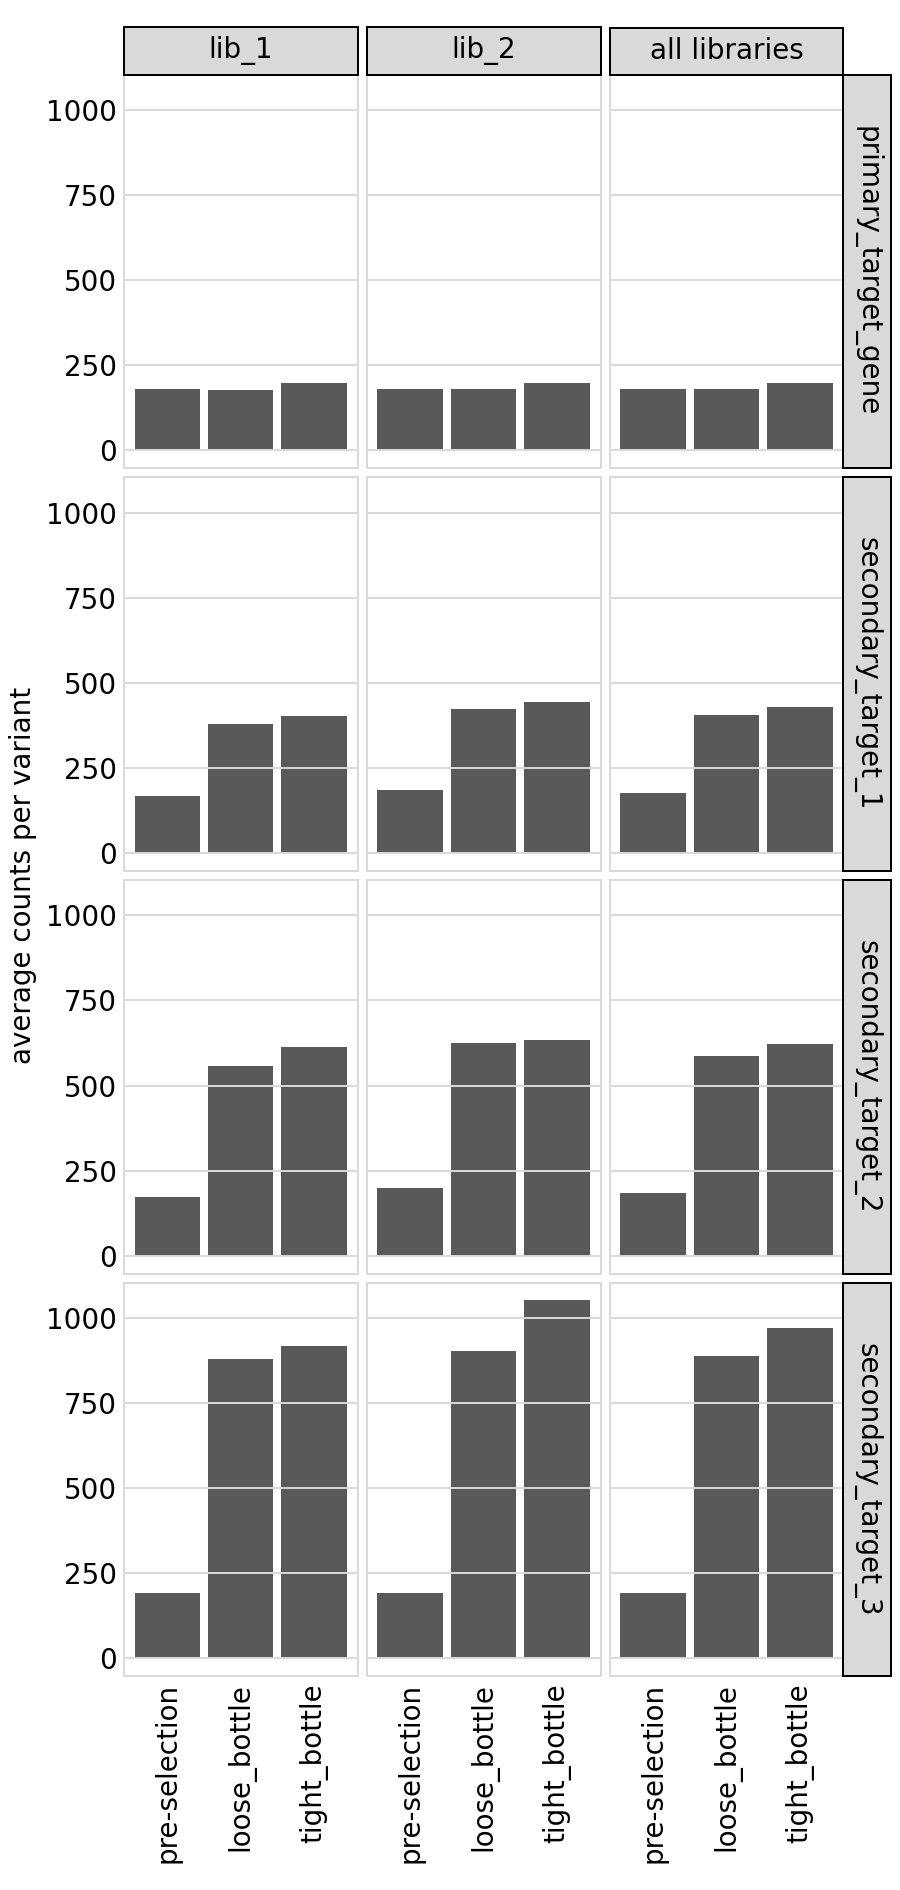

In [44]:
# NBVAL_IGNORE_OUTPUT

p = variants.plotAvgCountsPerVariant(heightscale=1.5, orientation="h")
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)

Here is the same plot **not** faceted by target:

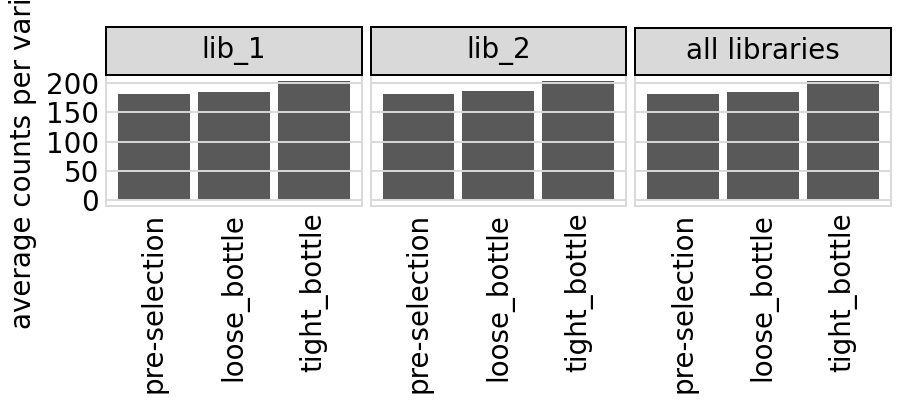

In [45]:
# NBVAL_IGNORE_OUTPUT

p = variants.plotAvgCountsPerVariant(orientation="h", by_target=False)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)

Plot the number of counts for each variant in each sample. 
The horizontal
dashed line shows the total number of variants. 
The plot shows that all
variants are well-sampled in the pre-selection libraries, but that post-
selection some variants are sampled more or less.
This is expected since
selection will decrease and increase the frequency of variants.
By default, this plot shows only the primary target:

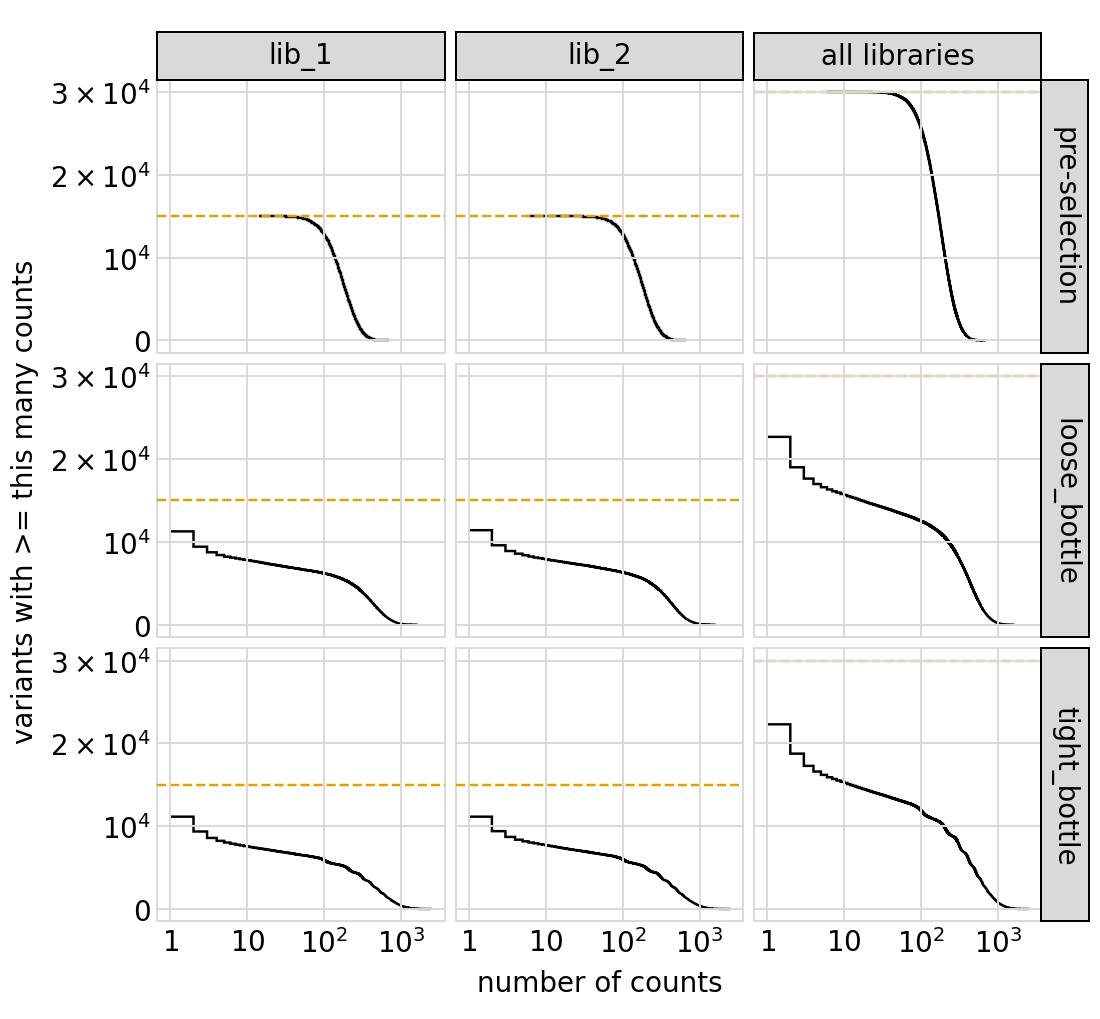

In [46]:
# NBVAL_IGNORE_OUTPUT

p = variants.plotCumulVariantCounts()
_ = p.draw(show=True)

Similar plot showing all targets:

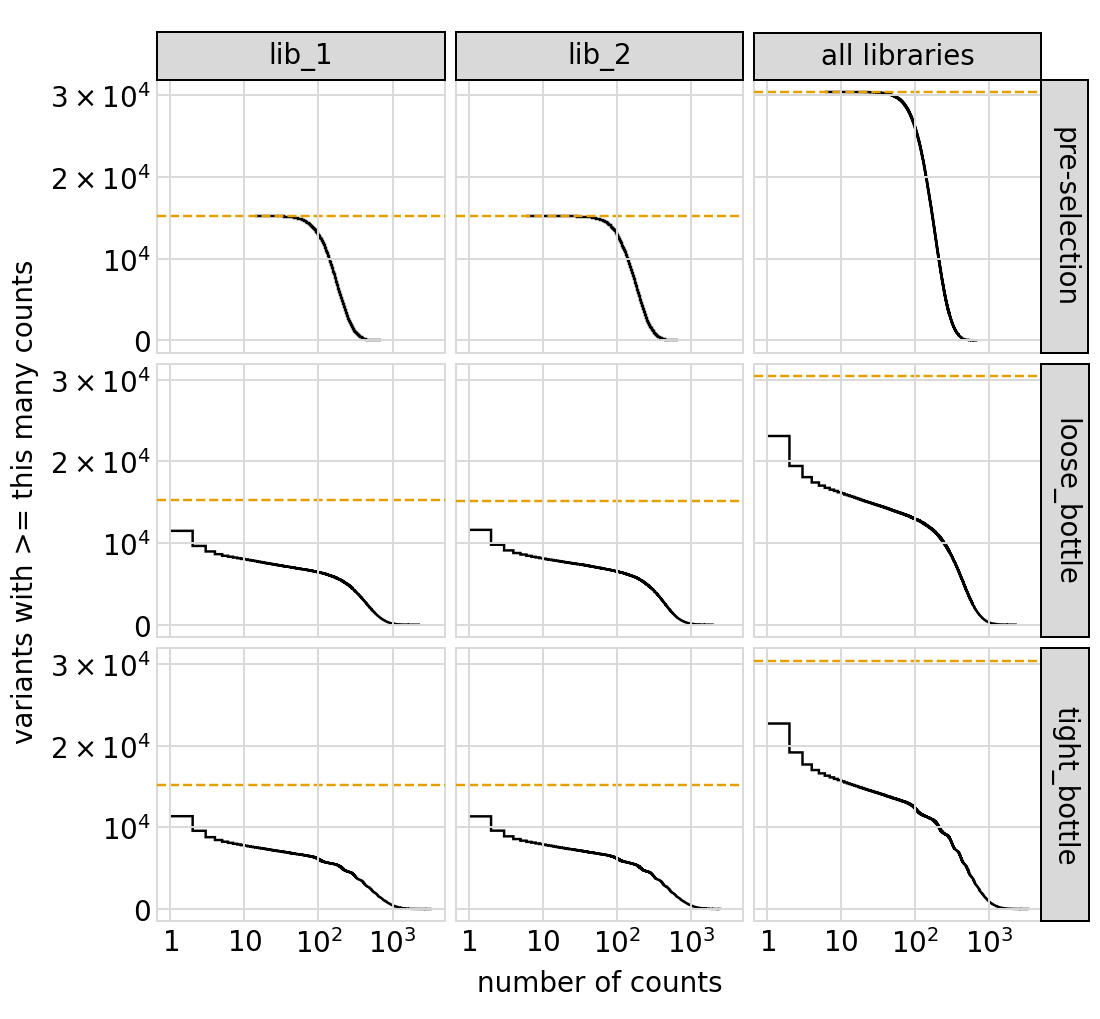

In [47]:
# NBVAL_IGNORE_OUTPUT

p = variants.plotCumulVariantCounts(primary_target_only=False)
_ = p.draw(show=True)

Number of counts per variant:

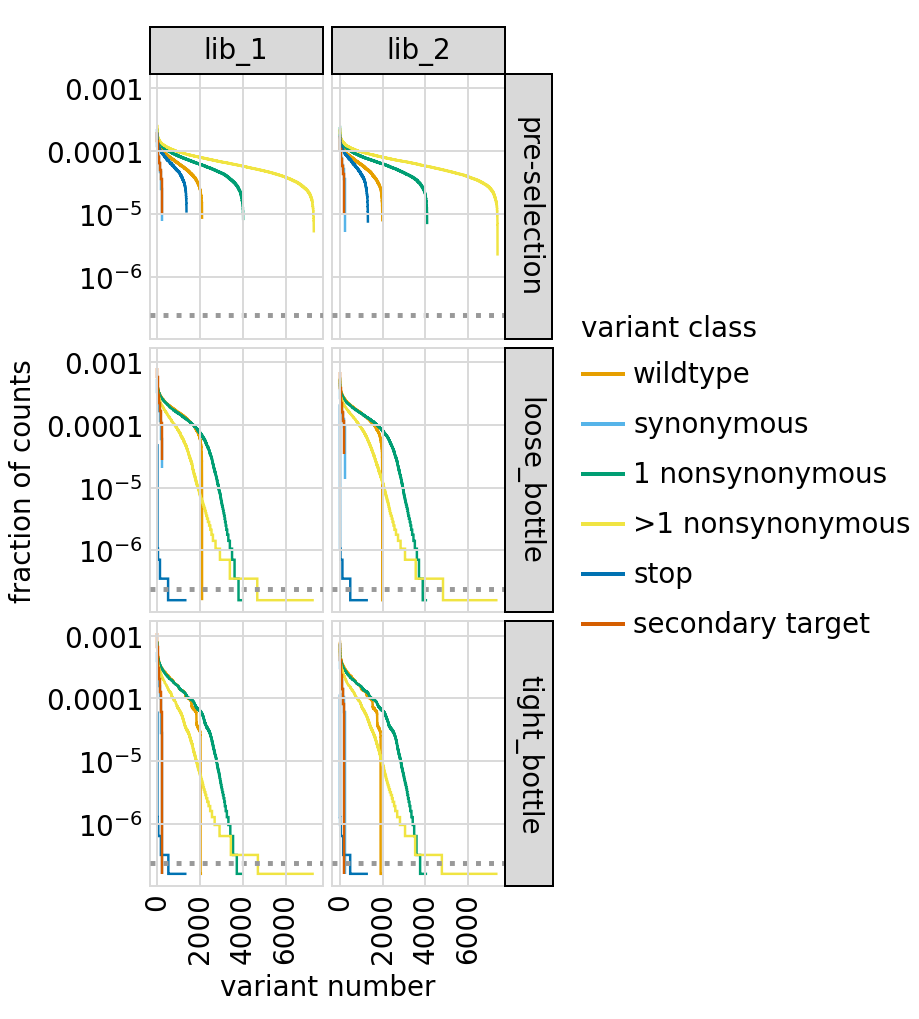

In [48]:
# NBVAL_IGNORE_OUTPUT

p = variants.plotCountsPerVariant(libraries=variants.libraries, by_variant_class=True)
_ = p.draw(show=True)

Similar plot only for primary targets:

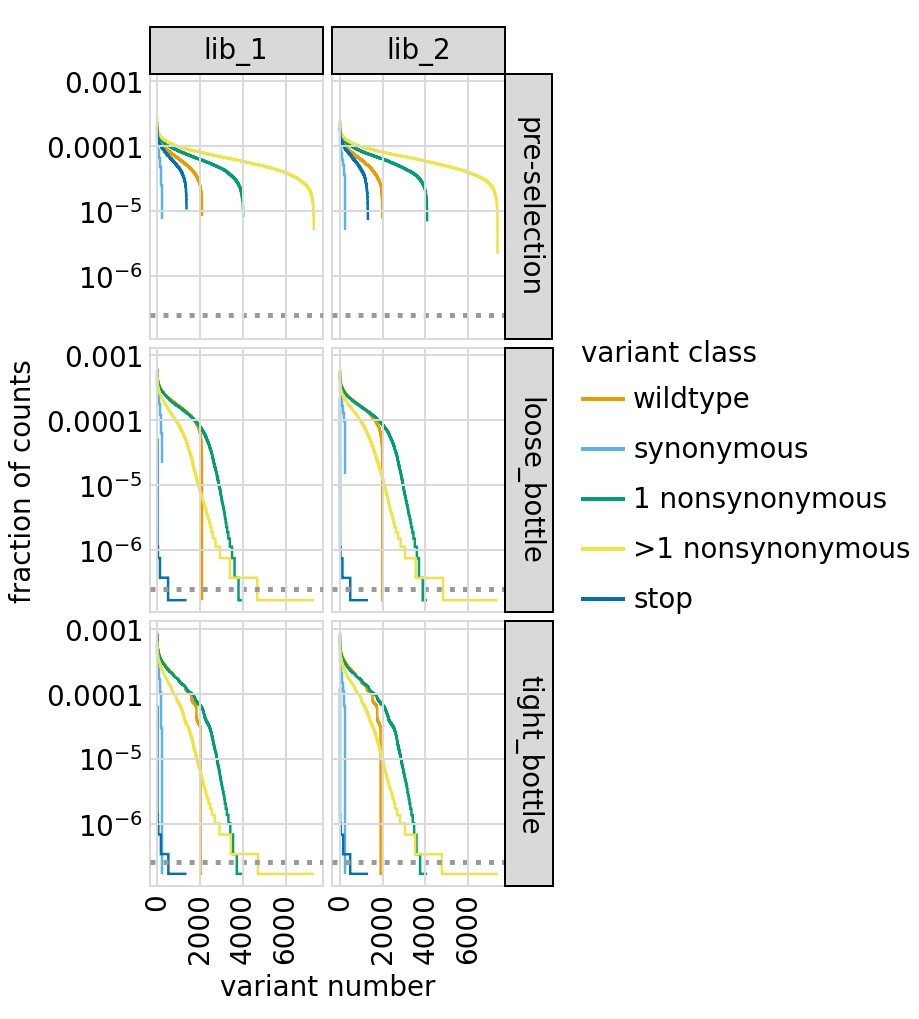

In [49]:
# NBVAL_IGNORE_OUTPUT

p = variants.plotCountsPerVariant(
    libraries=variants.libraries, by_variant_class=True, primary_target_only=True
)

_ = p.draw(show=True)

Distribution of the number of amino-acid mutations per variant in each sample.
This is only for the primary target.
As expected, mutations go down after selection:

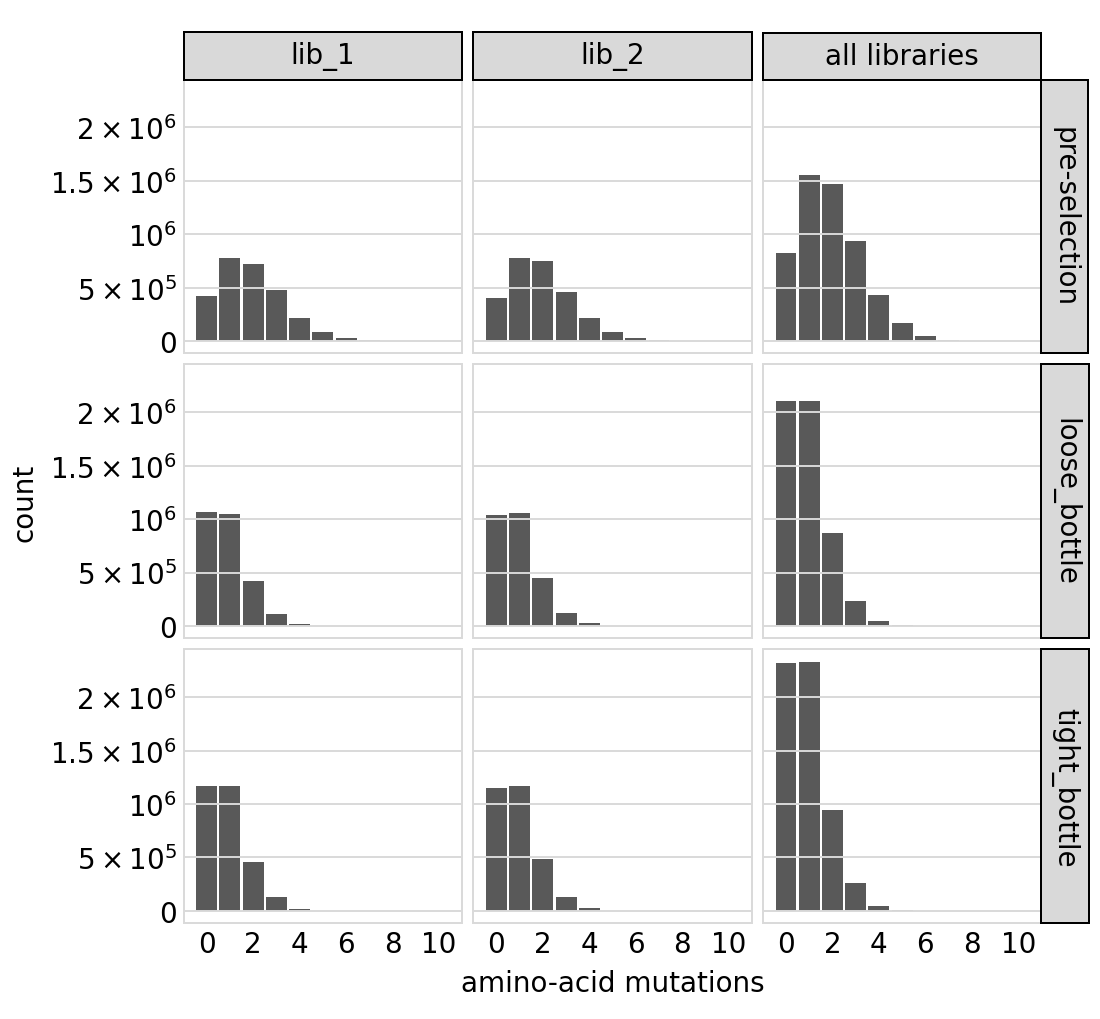

In [50]:
# NBVAL_IGNORE_OUTPUT

p = variants.plotNumMutsHistogram(mut_type="aa")
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)

Average number of mutations of each type per variant among just single mutants
(and wildtype) and among all variants, again only for primary target:

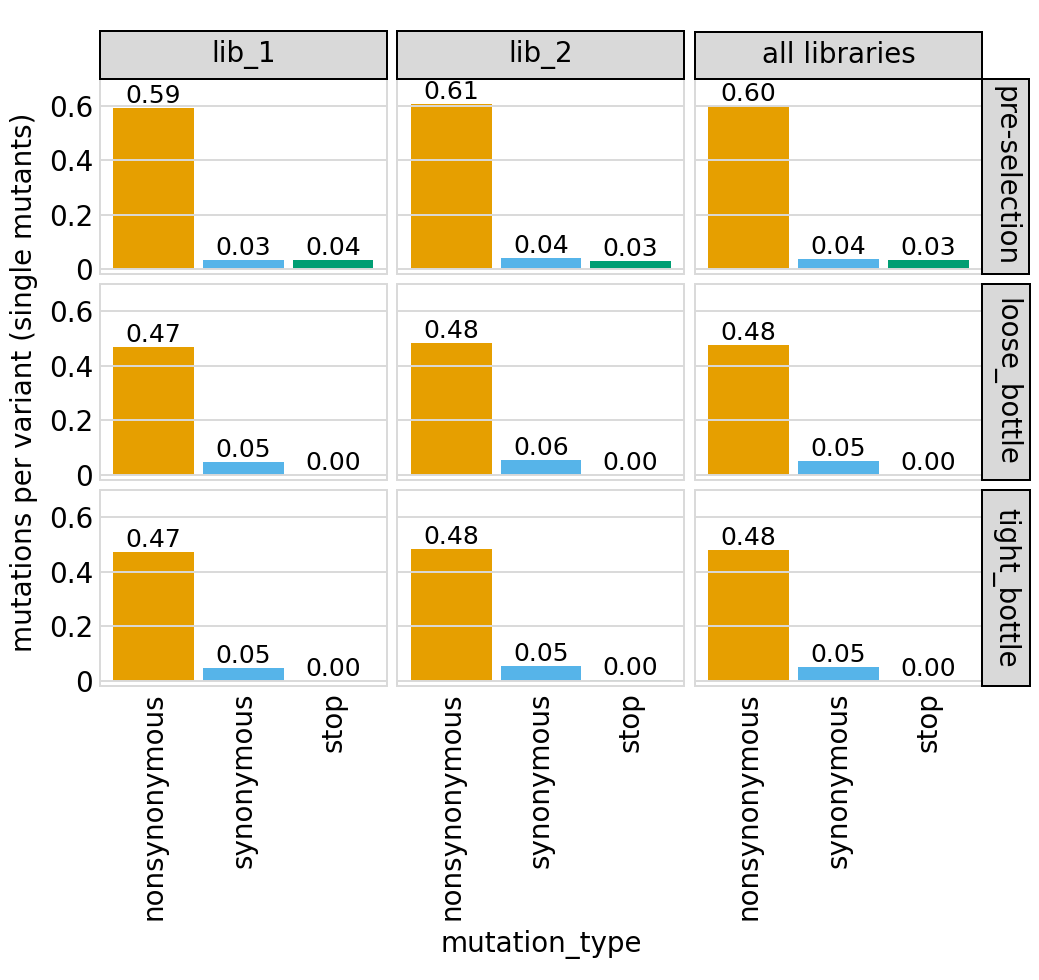

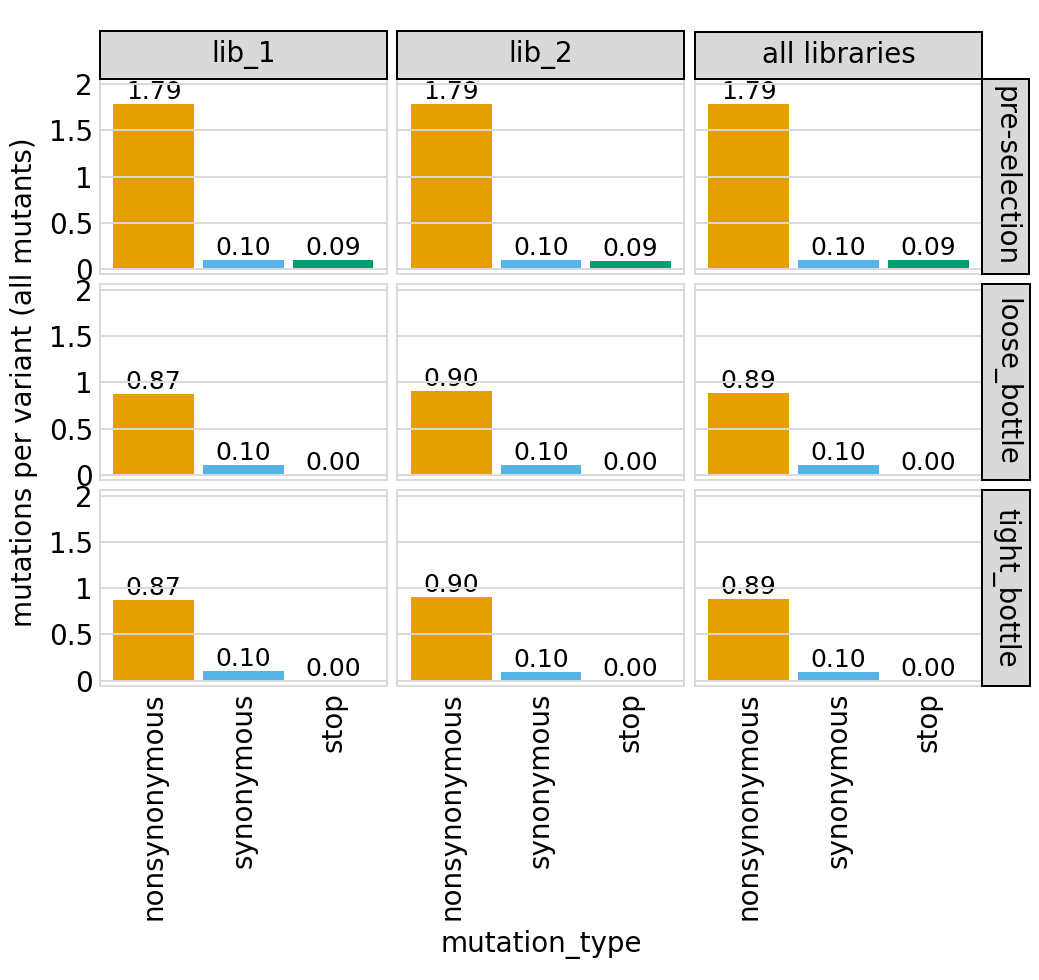

In [51]:
# NBVAL_IGNORE_OUTPUT

for variant_type in ["single", "all"]:
    p = variants.plotNumCodonMutsByType(variant_type)
    p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    _ = p.draw(show=True)

Here are the numerical data plotted above (just for the individual libraries and all mutations):

In [52]:
# NBVAL_IGNORE_OUTPUT

variants.numCodonMutsByType(variant_type="all", libraries=libs).round(3)

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,pre-selection,nonsynonymous,4864651,2719365,1.789
1,lib_1,pre-selection,synonymous,275311,2719365,0.101
2,lib_1,pre-selection,stop,257132,2719365,0.095
3,lib_1,loose_bottle,nonsynonymous,2330462,2674231,0.871
4,lib_1,loose_bottle,synonymous,270348,2674231,0.101
5,lib_1,loose_bottle,stop,809,2674231,0.000
6,lib_1,tight_bottle,nonsynonymous,2574335,2949688,0.873
7,lib_1,tight_bottle,synonymous,289539,2949688,0.098
8,lib_1,tight_bottle,stop,948,2949688,0.000
9,lib_2,pre-selection,nonsynonymous,4872431,2720602,1.791


Here are mutation frequencies as a function of primary sequence among all variants of the primary target:

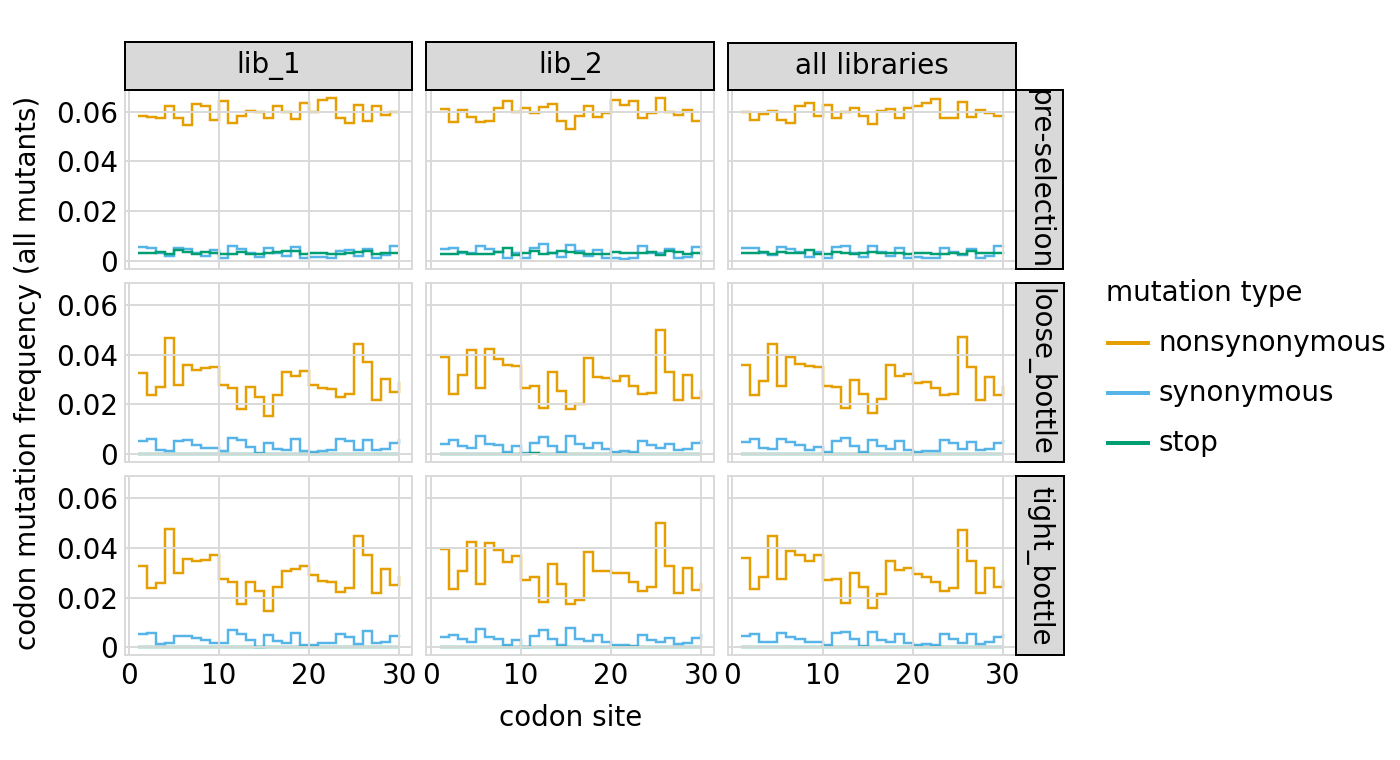

In [53]:
# NBVAL_IGNORE_OUTPUT

p = variants.plotMutFreqs(variant_type="all", mut_type="codon")
_ = p.draw(show=True)

Plot how thoroughly amino-acid mutations are sampled, doing this separately among all variants and single-mutant variants for the primary target.
The plots below show that the stop mutations are sampled very poorly post-selection because they are eliminated during selection:

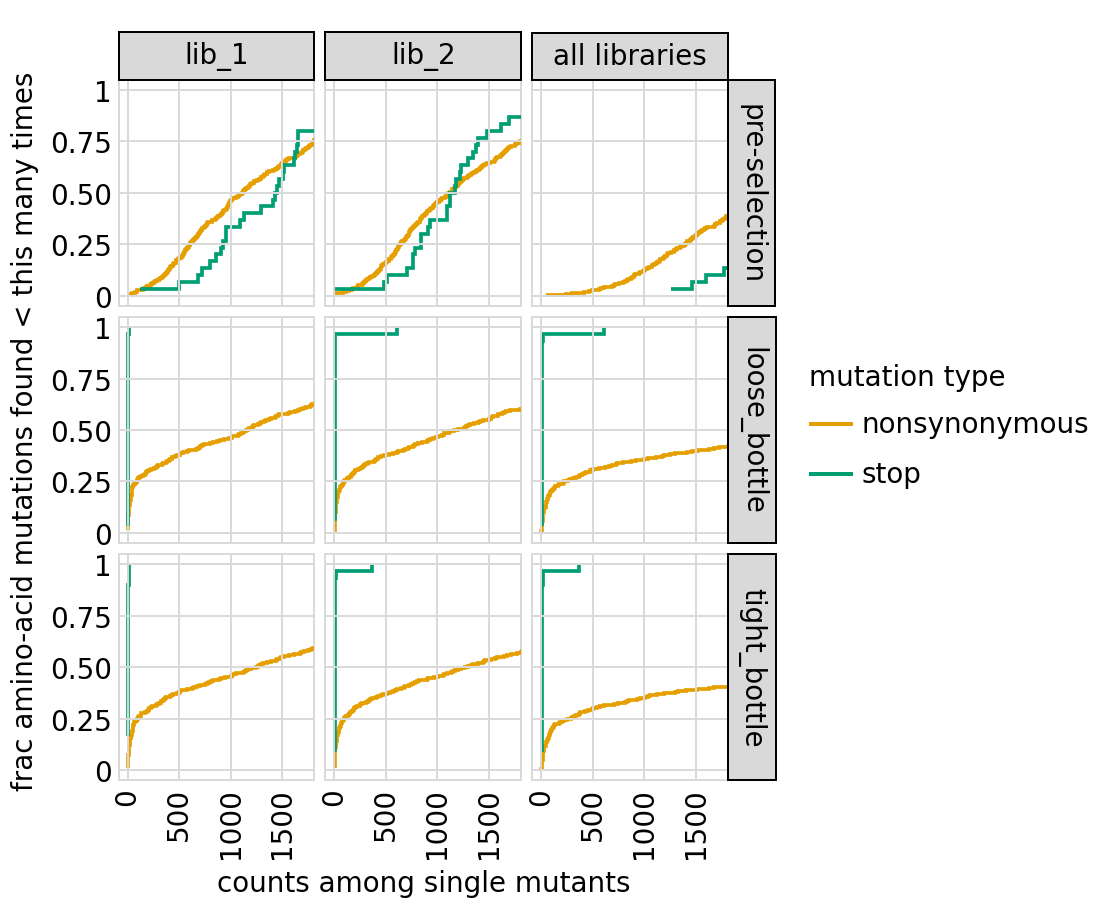

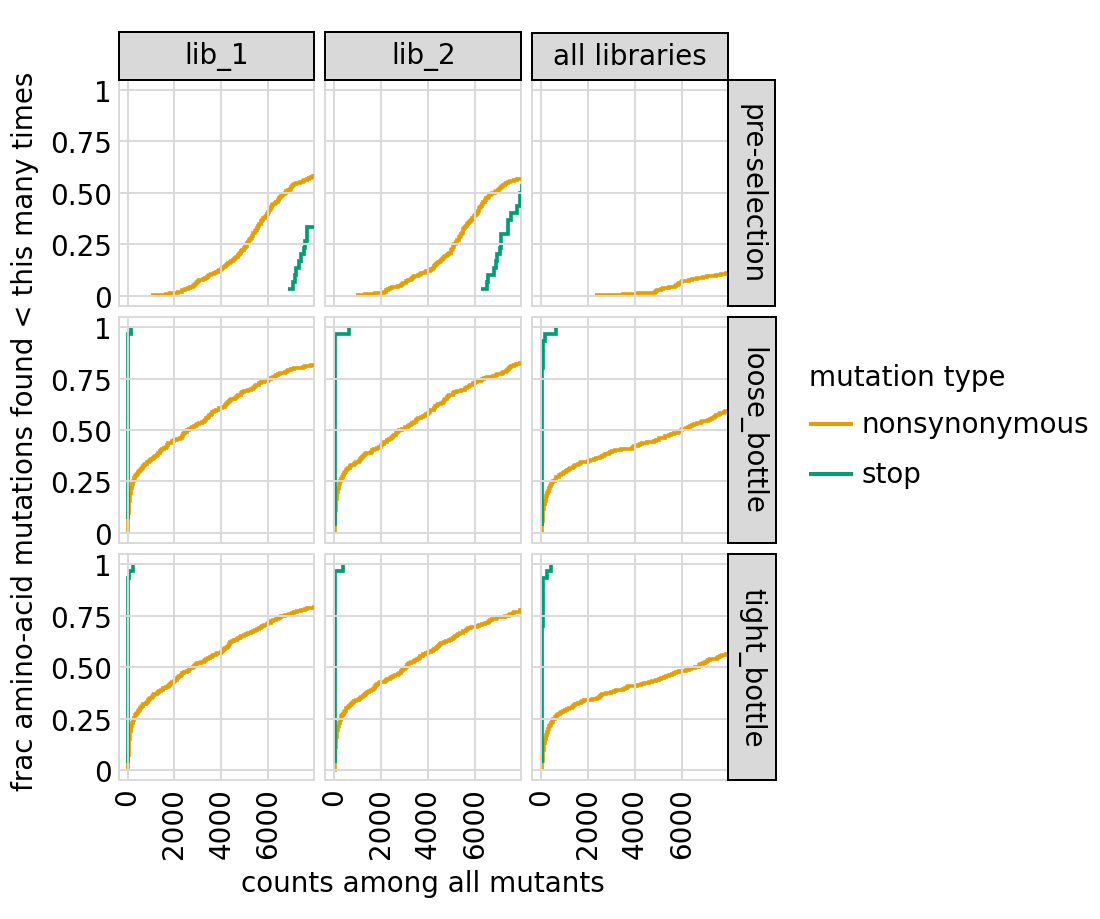

In [54]:
# NBVAL_IGNORE_OUTPUT

for variant_type in ["single", "all"]:
    p = variants.plotCumulMutCoverage(variant_type=variant_type, mut_type="aa")
    _ = p.draw(show=True)

## Functional scores for variants
The
[CodonVariantTable.func_scores](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.func_scores)
method calculates a functional score for each variant based on its change in
frequency from pre- to post-selection.

To calculate these scores, we
need to pair each
post-selection sample with a pre-selection one.
In this case,
the pre-selection sample is named 'pre-selection' for all post-selection
samples:

In [55]:
func_scores = variants.func_scores("pre-selection", libraries=libs)

The resulting data frame has a functional score (and its
variance) for each barcoded variant:

In [56]:
# NBVAL_IGNORE_OUTPUT

func_scores.round(3)

,target,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,codon_substitutions,n_codon_substitutions,aa_substitutions,n_aa_substitutions
0,primary_target_gene,lib_1,pre-selection,loose_bottle,AACCCGTTCACCACCA,-1.060,0.005,692,847,381697,973820,0.5,ATC17CGA CGG29TGC,2,I17R R29C,2
1,primary_target_gene,lib_1,pre-selection,loose_bottle,ACTACGGACGATTATT,-3.845,0.022,633,112,381697,973820,0.5,GCT7TCT AAA14GAT AAC20CGA,3,A7S K14D N20R,3
2,primary_target_gene,lib_1,pre-selection,loose_bottle,GGACTATCTCAGTATG,-0.188,0.005,615,1378,381697,973820,0.5,,0,,0
3,primary_target_gene,lib_1,pre-selection,loose_bottle,CCAGAAAACCCACCAA,-0.052,0.005,614,1512,381697,973820,0.5,TTA18CTC,1,,0
4,primary_target_gene,lib_1,pre-selection,loose_bottle,ACGGCCTAAACTCACA,-3.228,0.016,611,166,381697,973820,0.5,CGT6GTA GAC22CAC,2,R6V D22H,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60863,secondary_target_3,lib_2,pre-selection,tight_bottle,TGTGCTTAGAGCACCG,0.953,0.033,74,412,359334,1028011,0.5,secondary_target_3,0,secondary_target_3,0
60864,secondary_target_3,lib_2,pre-selection,tight_bottle,CCTGGATTTCTGATTT,1.546,0.034,69,580,359334,1028011,0.5,secondary_target_3,0,secondary_target_3,0
60865,secondary_target_3,lib_2,pre-selection,tight_bottle,CAGTGGTAATTAAACG,-8.614,4.193,68,0,359334,1028011,0.5,secondary_target_3,0,secondary_target_3,0
60866,secondary_target_3,lib_2,pre-selection,tight_bottle,CTTGTTGTATACTAGC,2.630,0.042,52,929,359334,1028011,0.5,secondary_target_3,0,secondary_target_3,0


We can also calculate functional scores at the level of amino-acid or codon
substitutions rather than at the level of variants. 
This calculation groups all
variants with the same substitutions before calculating the functional score.
Here are scores grouping by amino-acid substitutions; we also set
`syn_as_wt=True` to include variants with only synonymous mutations in the
counts of wild type in this case:

In [57]:
# NBVAL_IGNORE_OUTPUT

aa_func_scores = variants.func_scores(
    "pre-selection", by="aa_substitutions", syn_as_wt=True, libraries=libs
)
aa_func_scores.round(3)

,target,library,pre_sample,post_sample,aa_substitutions,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions
0,primary_target_gene,lib_1,pre-selection,loose_bottle,I17R R29C,-1.062,0.005,692,847,418909,1070114,0.5,2
1,primary_target_gene,lib_1,pre-selection,loose_bottle,A7S K14D N20R,-3.846,0.022,633,112,418909,1070114,0.5,3
2,primary_target_gene,lib_1,pre-selection,loose_bottle,,0.000,0.000,418909,1070114,418909,1070114,0.5,0
3,primary_target_gene,lib_1,pre-selection,loose_bottle,R6V D22H,-3.230,0.016,611,166,418909,1070114,0.5,2
4,primary_target_gene,lib_1,pre-selection,loose_bottle,R1A,0.119,0.002,1863,5168,418909,1070114,0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,secondary_target_1,lib_2,pre-selection,tight_bottle,secondary_target_1,-0.237,0.000,15119,36473,404611,1150576,0.5,0
35996,secondary_target_2,lib_1,pre-selection,tight_bottle,secondary_target_2,0.339,0.000,15418,54461,418909,1169889,0.5,0
35997,secondary_target_2,lib_2,pre-selection,tight_bottle,secondary_target_2,0.161,0.000,13766,43769,404611,1150576,0.5,0
35998,secondary_target_3,lib_1,pre-selection,tight_bottle,secondary_target_3,0.788,0.000,16580,79965,418909,1169889,0.5,0


We can plot the distribution of the functional scores for variants.
These plots
are most informative if we classify variants
by the “types” of mutations they
have, which we do here using the
[CodonVariantTable.classifyVariants](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.classifyVariants)
method, which adds a  column called `variant_class` to the data frame.
Note that we have to specify the primary target and how to classify non-primary targets:

In [58]:
func_scores = dms_variants.codonvarianttable.CodonVariantTable.classifyVariants(
    func_scores,
    primary_target=variants.primary_target,
    non_primary_target_class="secondary target",
)

(func_scores[["target", "codon_substitutions", "aa_substitutions", "variant_class"]])

,target,codon_substitutions,aa_substitutions,variant_class
0,primary_target_gene,ATC17CGA CGG29TGC,I17R R29C,>1 nonsynonymous
1,primary_target_gene,GCT7TCT AAA14GAT AAC20CGA,A7S K14D N20R,>1 nonsynonymous
2,primary_target_gene,,,wildtype
3,primary_target_gene,TTA18CTC,,synonymous
4,primary_target_gene,CGT6GTA GAC22CAC,R6V D22H,>1 nonsynonymous
...,...,...,...,...
60863,secondary_target_3,secondary_target_3,secondary_target_3,secondary target
60864,secondary_target_3,secondary_target_3,secondary_target_3,secondary target
60865,secondary_target_3,secondary_target_3,secondary_target_3,secondary target
60866,secondary_target_3,secondary_target_3,secondary_target_3,secondary target


Now we use [plotnine](https://plotnine.readthedocs.io) to plot the distributions
of scores in ggplot2-like syntax, coloring by the variant class.
This plot shows
the expected behavior for different variant classes; for instance, stop codon
variants tend to have low scores and synonymous variants tend to have wildtype-like (near 0) scores.
As expected, there is more noise with a tighter bottleneck:

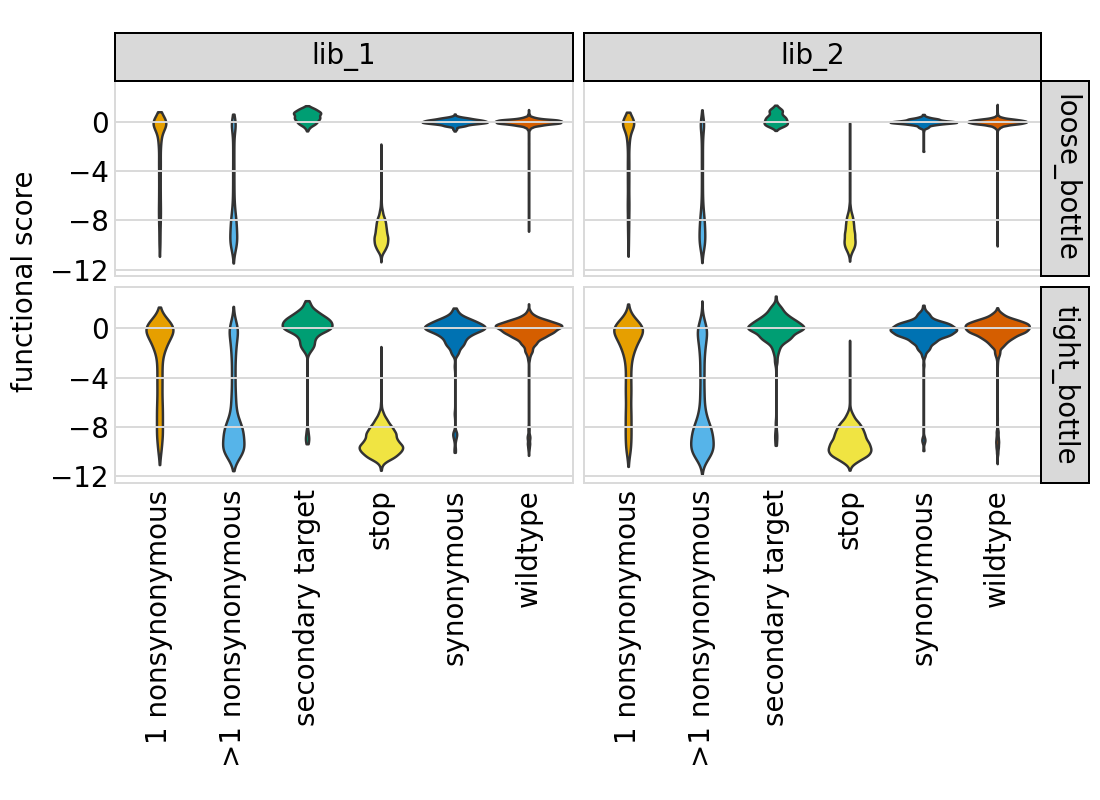

In [59]:
# NBVAL_IGNORE_OUTPUT

p = (
    ggplot(func_scores, aes("variant_class", "func_score"))
    + geom_violin(aes(fill="variant_class"))
    + ylab("functional score")
    + xlab("")
    + facet_grid("post_sample ~ library")
    + theme(
        figure_size=(2.75 * len(libs), 2 * len(bottlenecks)),
        axis_text_x=element_text(angle=90),
        panel_grid_major_x=element_blank(),  # no vertical grid lines
    )
    + scale_fill_manual(values=CBPALETTE[1:])
)

_ = p.draw(show=True)